## Solution to the reaction-diffusion profile around a Janus particle

In this notebook, I compute the solution of the reaction-diffusion

$$(\nabla^2-\kappa^2) f = 0$$

with a reactive boundary condition on a sphere centered at the origin
of the coordinate system, with azimuthal symmetry.

In general, one can write these solutions as

$$c = \sum_{l=0}^\infty a_l \frac{\sqrt{\kappa r_0}}{K_{l+1/2}(\kappa r_0)} \frac{K_{l+1/2}(\kappa r)}{\sqrt{\kappa r}} P_l(\cos\theta)$$

Here, the problem is specified by having only the top half of the sphere catalytic.

The $K_{l+1/2}$ are the modified Bessel function or half-integer order.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
from scipy import integrate
import itertools
from glob import glob
import h5py

π = np.pi

plt.rcParams['figure.figsize'] = (8*.7, 6*.7)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 16


### Getting the Legendre polynomials

In [2]:
# Define a range of 
mu_r = np.linspace(-1, 1, 101)

<IPython.core.display.Javascript object>


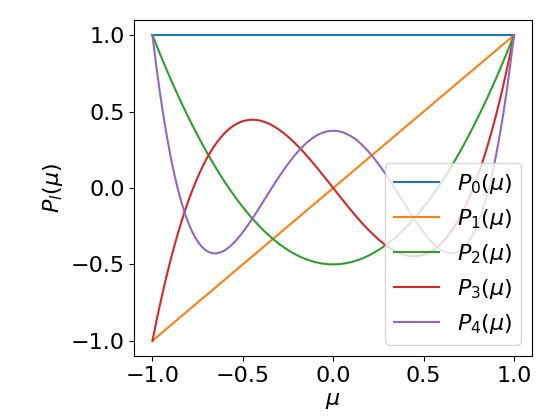

In [3]:
plt.figure()
[plt.plot(mu_r, special.legendre(i)(mu_r), label=r'$P_%i(\mu)$' % i) for i in range(5)];
plt.xlabel(r'$\mu$')
plt.ylabel(r'$P_l(\mu)$')
plt.legend()

### Getting the Bessel function

<IPython.core.display.Javascript object>


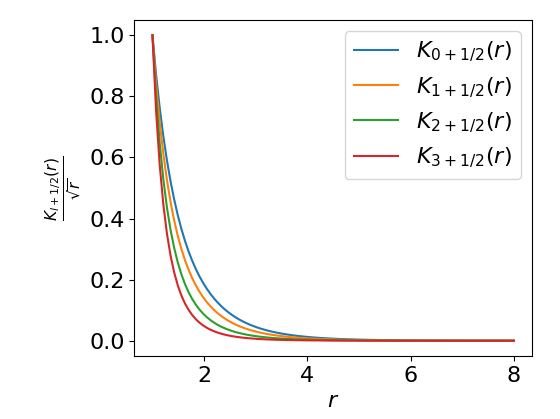

In [4]:
plt.figure()
r_range = np.linspace(1, 8, 101)

[plt.plot(r_range, special.kv(i+0.5, r_range)/np.sqrt(r_range)/special.kv(i+0.5, r_range[0]), label=r'$K_{'+str(i)+r'+1/2}(r)$') for i in [0, 1, 2, 3]]

plt.xlabel(r'$r$')
plt.ylabel(r'$\frac{K_{l+1/2}(r)}{\sqrt{r}}$')
plt.legend()

## Definition of the problem

Having written the solution as

$$\sum_l M_{jl} a_l = b_j$$

We must compute $M_{jl}$ and $b_j$

$$m_jl = \frac{k_0}{k_D}  \int_0^1 d\mu\ P_l(\mu) P_j(\mu) + r_0 \kappa \left[ \frac{K_{l+3/2}(\kappa r_0)}{K_{l+1/2}(\kappa r_0)} -\frac{l}{\kappa r_0}\right] \frac{2}{2l+1}\delta_{l,j}$$


### Compute integrals of Legendre polynomials

Here, we compute $\int_0^1 P_l(\mu) P_j(\mu) d\mu$ and $\int_0^1 P_j(\mu) d\mu$

In [5]:
def legendre_int_lj(l, j):
    Pl = special.legendre(l)
    Pj = special.legendre(j)
    sol, err = integrate.quad(lambda mu: Pl(mu)*Pj(mu), 0, 1)
    return sol

def legendre_int_j(j):
    Pj = special.legendre(j)
    sol, err = integrate.quad(lambda mu: Pj(mu), 0, 1)
    return sol

### Compute the Bessel term

$$\frac{K_{l+3/2}(\kappa r_0)}{K_{l+1/2}(\kappa r_0)}$$

In [6]:
def bessel_term(l, kr0):
    return special.kv(l+1.5, kr0)/special.kv(l+0.5,kr0)

### Build the left-hand side matrix

In [7]:
Ncut = 40

M = np.zeros((Ncut, Ncut))
delta = np.eye(Ncut)

c0 = 10
T = 1
m = 1
p = 1
R = 3.5
D = 1.17
kD = 4*π*R*D
k0 = p*R**2*np.sqrt(8*π*T/m)
k2 = 0.02
κ = np.sqrt(k2/D)
layer = np.sqrt(3)/2
layer = 0.5
r0 = R+layer

for i, j in itertools.product(range(Ncut), range(Ncut)):
    T1 = k0/kD * legendre_int_lj(i, j)
    T2 = (r0*κ*bessel_term(j, κ*r0) - j)*2/(2*j+1)*delta[i,j]
    M[i,j] = T1+T2


### Build the right-hand side vector

In [8]:
b = k0/kD * np.array([legendre_int_j(j) for j in range(Ncut)])

### Solve

In [9]:
a = np.linalg.solve(M, b)

In [10]:
# Verification

assert np.allclose(np.dot(M, a), b)

### Define the solution $c(r, \mu)$

In [11]:
def c(r, mu):
    res = 0
    for i in range(Ncut):
        res += a[i]*special.legendre(i)(mu)*special.kv(i+0.5, κ*r)/np.sqrt(κ*r)/(special.kv(i+0.5, κ*r0)/np.sqrt(κ*r0))
    return res

In [12]:
# Compute the solution on a grid

MU = np.linspace(-1, 1, 64)
RR = np.linspace(R, 7, 64)

data = [[c(r, mu) for r in RR] for mu in MU]
data = c0*np.array(data)

# Convert to cartesian coordinates for display
X = RR.reshape((1,-1)) * np.sqrt(1-MU**2).reshape((-1, 1))
Z = RR.reshape((1,-1)) * MU.reshape((-1, 1))


In [13]:

for fname in glob('path/to/active/simulations/janus.h5'):
    simu_c_data = []
    with h5py.File(fname, 'r') as f:
        simu_c = f['fields/polar_concentration']
        simu_v = f['fields/polar_velocity']
        simu_r_min = simu_c.attrs['r_min'][()]
        simu_r_max = simu_c.attrs['r_max'][()]
        simu_dr = simu_c.attrs['dr'][()]
        simu_dtheta = simu_c.attrs['dtheta'][()]

        simu_c = simu_c[:]
        simu_v = simu_v[:]

        simu_N_r, simu_N_theta = simu_c.shape[:2]

        # r and th must overshoot c.shape by one for pcolormesh
        simu_r = simu_r_min + np.arange(simu_N_r+1)*simu_dr
        simu_r = simu_r.reshape((-1,1))
        simu_th = (np.arange(simu_N_theta+1)+0.5)*simu_dtheta
        simu_th = simu_th.reshape((1,-1))

        simu_c[:,:,0] /= (2*np.pi*simu_r**2*np.sin(simu_th)*simu_dr*simu_dtheta)[:-1,:-1]
        simu_c[:,:,1] /= (2*np.pi*simu_r**2*np.sin(simu_th)*simu_dr*simu_dtheta)[:-1,:-1]

        simu_X = simu_r*np.sin(simu_th)
        simu_Z = simu_r*np.cos(simu_th)
        simu_c_data.append(simu_c)
simu_c = np.mean(np.array(simu_c_data), axis=0)

<IPython.core.display.Javascript object>


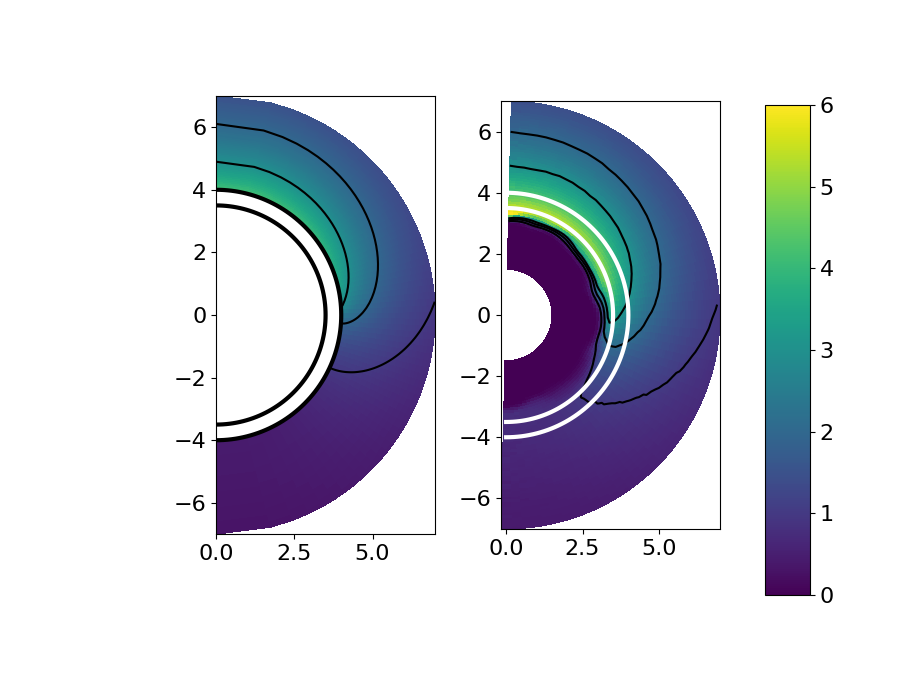

In [14]:
tmp_th = np.linspace(0, np.pi, 101)

fig = plt.figure(figsize=(9, 7))
plt.subplot(121, aspect=1)

masked_data = np.ma.array(data, mask=(X**2+Z**2) < r0**2)
cm = plt.pcolormesh(X, Z, masked_data, rasterized=True, vmin=0, vmax=6)

plt.contour(X, Z, masked_data, [1, 2, 3], colors='k')
plt.plot(R*np.sin(tmp_th), R*np.cos(tmp_th), 'k', lw=3)
plt.plot(r0*np.sin(tmp_th), r0*np.cos(tmp_th), 'k', lw=3)

plt.subplot(122, aspect=1)

plt.pcolormesh(simu_X, simu_Z, simu_c[:,:,1], cmap=plt.cm.viridis, rasterized=True, vmin=0, vmax=6)
plt.contour(simu_X[:-1,:-1], simu_Z[:-1,:-1], simu_c[:,:,1], [1, 2, 3], colors='k')

plt.plot(R*np.sin(tmp_th), R*np.cos(tmp_th), 'w', lw=3)
plt.plot(r0*np.sin(tmp_th), r0*np.cos(tmp_th), 'w', lw=3)

if False:
    plt.subplot(133, aspect=1)
    plt.pcolormesh(X, Z, data_cb, rasterized=True, vmin=0, vmax=6)

    plt.contour(X, Z, data_cb, [1, 2, 3], colors='k')
    plt.plot(R*np.sin(tmp_th), R*np.cos(tmp_th), 'k', lw=3)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cm, cax=cbar_ax)

plt.savefig('janus_concentration_field_EPSB0100.pdf')

<IPython.core.display.Javascript object>


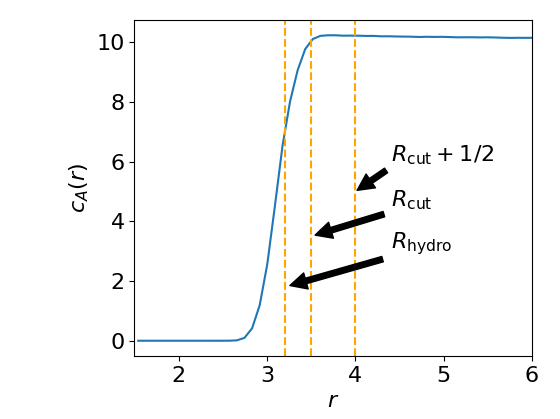

In [15]:
plt.figure()

plt.plot((simu_r[1:,0]+simu_r[:-1,0])/2, np.mean(simu_c[:,:,0], axis=1)+np.mean(simu_c[:,:,1], axis=1))

R_hydro = 3.2

plt.xlabel(r'$r$')
plt.ylabel(r'$c_A(r)$')
plt.xlim(1.5, 6)

plt.axvline(R_hydro, c='orange', ls='--')
plt.annotate(r'$R_\mathrm{hydro}$', xy=(R_hydro, 2-0.2), xytext=(r0+0.4, 3.1), arrowprops=dict(facecolor='black', shrink=0.05),
)
plt.axvline(R, c='orange', ls='--')
plt.annotate(r'$R_\mathrm{cut}$', xy=(R, 3.5), xytext=(r0+0.4, 4.5), arrowprops=dict(facecolor='black', shrink=0.05),
)

plt.axvline(r0, c='orange', ls='--')
plt.annotate(r'$R_\mathrm{cut} + 1/2$', xy=(r0, 5), xytext=(r0+0.4, 6), arrowprops=dict(facecolor='black', shrink=0.05),
)

plt.savefig('janus_eq_radial_c.pdf')